In [1]:
# Analysing initial outputs from Maggie's game
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy as ent
import pyphi
import time
import math

import sys
sys.path.insert(0, '/Users/bjornjuel/projects/actual_agency_fork/')

from pyanimats import *
from actual_agency import *
import pyphi

pyphi.config.VALIDATE_SUBSYSTEM_STATES = False
pyphi.config.PARTITION_TYPE = 'TRI'

%load_ext autoreload
%autoreload 2


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [210]:
# some functions for generating TPM and activity pattern for toy systems
def gen_cm(n_nodes,n_sensors):
    

    # first, indicate the node types (excitatory (+1) or inhibitory (-1))
    node_types = 2*np.random.randint(0,2,size=(n_nodes))-1
    
    # next, produce binary CM to indicate wether or not there is a connection
    connection = np.random.randint(2,size=(n_nodes,n_nodes))
    
    # then, set synaptic weights for individual connections
    w = np.random.rand(n_nodes,n_nodes)
    
    # finally, produce CM
    cm = np.array([[w[i,j]*node_types[j]*connection[i,j] for i in range(n_nodes)] for j in range(n_nodes)])
    cm[:,:2] = 0
    cm[2:4,:] = 0
    
    cm = np.around(cm,decimals=2)
    
    return cm

def get_states(n_nodes):
    return np.array(([list(('{:0'+str(n_nodes)+'d}').format(int(bin(x)[2:]))) for x in range(2**n_nodes)])).astype(int)

def next_state(cm,activation,state):
    
    node_input = np.matmul(state,cm)
    
    if activation == 'sigmoid':
        p_activation = [sigmoid(i) for i in node_input]
        
    elif activation == 'deterministic':
        p_activation = [1 if i>0 else 0 for i in node_input]
        
    return p_activation


def sample_tpm(cm,activation):
    
    nodes = cm.shape[0]
    next_states = np.zeros((2**nodes,nodes))
    states = get_states(nodes)
    
    for state,row in zip(states,range(2**nodes)):
        next_states[row,:] = next_state(cm,activation,state)
            
    return next_states


def gen_tpm(n_sensors, n_nodes,activation = 'sigmoid'):
    
    total_nodes = n_sensors + n_nodes
    
    # generate a CM
    cm = gen_cm(total_nodes,n_sensors)
    
    # Generates TPM for the agent.
    
    tpm = sample_tpm(cm,'sigmoid')
    
    tpm = pyphi.convert.to_multidimensional(tpm)

    return tpm,cm


def sigmoid(x,slope=1,center=0):
    return 1 / (1 + math.exp(-slope*(x-center)))

def gen_BrainActivity(animat,trials,times,initial_state = None):
    tpm = animat.brain.tpm
    
    if initial_state == None:
        initial_state = np.random.randint(0,2,(trials,animat.n_nodes))
    elif len(initial_state)==animat.n_nodes:
        initial_state = np.matlib.repmat(initial_state,trials,1)
    elif not len(initial_state) == trials:
        print("randomizing intiial states as one was not defined for each trial")
        initial_state = np.random.randint(0,2,(trials,animat.n_nodes))
        
    threshold = np.random.rand(trials,times,animat.n_nodes)
    brain_activity = np.zeros((trials,times,animat.n_nodes))
    
    for trial in range(trials):
        brain_activity[trial,0,:] = initial_state[trial,:]
        for time in range(1,times):
            p_activation = tpm[tuple(brain_activity[trial,time-1,:].astype(int))]
            next_state = [1 if p>t else 0 for p,t in zip(p_activation,threshold[trial,time,:])]
            brain_activity[trial,time,:] = next_state
            
    return brain_activity.astype(int)
    

def save_phi_from_MCs(animat):
    '''

        Inputs:

        Outputs:
    '''

    phis = []
    for s in animat.unique_states:

        if animat.MCs[state2num(s)] == None:
            phis.append(0)
        else:
            phis.append(animat.MCs[state2num(s)].phi)
    animat.phis = phis





In [233]:
# creating an animat
n_sensors = 2
n_hidden = 4
n_motors = 2
animat = Animat({'hiddenNodes' : n_hidden})
tpm,cm = gen_tpm(n_sensors,n_hidden+n_motors)
animat.saveBrain(tpm,np.ceil(np.abs(cm)))

In [234]:
# creating brain activity from TPM
animat.saveBrainActivity(gen_BrainActivity(animat,1,20))


In [235]:
# finding and saving unique states and transitions
animat.saveUniqueTransitions()
animat.saveUniqueStates()

In [236]:
# calculating IIT parameters for all unique states 
pyphi.config.PROGRESS_BARS=False
animat.save_major_complex()

Finding MC for state number 0 out of 19 unique states
Finding MC for state number 1 out of 19 unique states
Finding MC for state number 2 out of 19 unique states
Finding MC for state number 3 out of 19 unique states
Finding MC for state number 4 out of 19 unique states
Finding MC for state number 5 out of 19 unique states
Finding MC for state number 6 out of 19 unique states
Finding MC for state number 7 out of 19 unique states
Finding MC for state number 8 out of 19 unique states
Finding MC for state number 9 out of 19 unique states
Finding MC for state number 10 out of 19 unique states
Finding MC for state number 11 out of 19 unique states
Finding MC for state number 12 out of 19 unique states
Finding MC for state number 13 out of 19 unique states
Finding MC for state number 14 out of 19 unique states
Finding MC for state number 15 out of 19 unique states
Finding MC for state number 16 out of 19 unique states
Finding MC for state number 17 out of 19 unique states
Finding MC for state

In [239]:
# calculating AC parameters for unique transitions
animat.save_unique_causal_links()

Finding causes for transition number 0 out of 19 unique transitions
Finding causes for transition number 1 out of 19 unique transitions
Finding causes for transition number 2 out of 19 unique transitions
Finding causes for transition number 3 out of 19 unique transitions
Finding causes for transition number 4 out of 19 unique transitions
Finding causes for transition number 5 out of 19 unique transitions
Finding causes for transition number 6 out of 19 unique transitions
Finding causes for transition number 7 out of 19 unique transitions
Finding causes for transition number 8 out of 19 unique transitions
Finding causes for transition number 9 out of 19 unique transitions
Finding causes for transition number 10 out of 19 unique transitions
Finding causes for transition number 11 out of 19 unique transitions
Finding causes for transition number 12 out of 19 unique transitions
Finding causes for transition number 13 out of 19 unique transitions
Finding causes for transition number 14 out 

In [240]:
save_phi_from_MCs(animat)

In [241]:
history = history_of_complexes(animat,only_state_changes=False)

In [242]:
MC_cause = get_causal_history(animat, 0,MC=True)

In [243]:
MC_cause

[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]

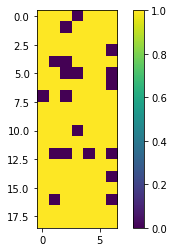

In [204]:

complex_cause_history = [[1 if i in cause else 0 for i in range(animat.n_nodes)] for cause in MC_cause]
plt.imshow(complex_cause_history)
plt.colorbar()

In [198]:
history

[[[0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 0, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 0]]]

In [206]:
occ = (2,3)
overlaps = [get_complex_purview_overlap(animat,trans,occ) for trans in animat.unique_transitions]

In [207]:
overlaps

[0.4,
 0.5,
 0.4,
 0.5,
 0.6,
 0.3333333333333333,
 0.6,
 0,
 0.4,
 0.6,
 0.3333333333333333,
 0.6,
 0.4,
 0.5,
 0.4,
 0.6,
 0.6,
 0.3333333333333333,
 0.3333333333333333]

In [124]:
get_union_of_causes(animat,animat.unique_transitions[0],(2,3))

(3,)

In [125]:
ba = np.vstack((animat.brain_activity,animat.brain_activity))

In [126]:
t = animat.unique_transitions[0]

In [127]:
animat.unique_transitions.index(t)

0

In [246]:
cm

array([[ 0.  ,  0.  , -0.  , -0.  , -0.  , -0.  , -0.37, -0.  ],
       [ 0.  ,  0.  ,  0.78,  0.  ,  0.29,  0.4 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.79,  0.16,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.34,  0.  ,  0.  ,  0.  ,  0.37,  0.  ],
       [ 0.  ,  0.  , -0.55, -0.  , -0.  , -0.79, -0.37, -0.37],
       [ 0.  ,  0.  , -0.74, -0.25, -0.  , -0.69, -0.8 , -0.  ]])

In [128]:

with open('animat.pkl', 'wb') as f:
    pickle.dump(animat, f, pickle.HIGHEST_PROTOCOL)

In [129]:

with open('animat.pkl', 'rb') as f:
    animat = pickle.load(f)

In [208]:
overlaps = [get_complex_purview_overlap(animat,trans,'MC') for trans in animat.unique_transitions] 

In [209]:
overlaps

[0.42857142857142855,
 0.42857142857142855,
 0.5714285714285714,
 0.6666666666666666,
 0.5,
 0.3333333333333333,
 0.6666666666666666,
 0.5,
 0.5714285714285714,
 0.42857142857142855,
 0.42857142857142855,
 0.5714285714285714,
 0.4,
 0.5714285714285714,
 0.6666666666666666,
 0.5714285714285714,
 0.8,
 0.5714285714285714,
 0.5714285714285714]

In [ ]:

    EEG(i) = pop_cleanline(EEG(i),'SignalType','Channels')
    EEG(i) = pop_eegfiltnew(EEG(i),0,100)
    EEG(i) = pop_select(EEG(i),'timerange',[1200 1800]);
    
    EEG_FRG(i) = pop_select(EEG(i),'channel',[1:20,65]);
    EEG_FRG(i) = pop_reref(EEG_FRG(i),[],'keepref','on');
    EEG_FRG(i) = eeg_regepochs(EEG_FRG(i),'recurrence',epochlength,'rmbase',epochlength,'eventtype','std','limits',[0 5]); 

    EEG_PRG(i) = pop_select(EEG(i),'channel',[21:36,65]);
    EEG_PRG(i) = pop_reref(EEG_PRG(i),[],'keepref','on');
    EEG_PRG(i) = eeg_regepochs(EEG_PRG(i),'recurrence',epochlength,'rmbase',epochlength,'eventtype','std','limits',[0 5]); 
    
    EEG_INFTEMP(i) = pop_select(EEG(i),'channel',[37:42,65]);
    EEG_INFTEMP(i) = pop_reref(EEG_INFTEMP(i),[],'keepref','on');
    EEG_INFTEMP(i) = eeg_regepochs(EEG_INFTEMP(i),'recurrence',1epochlength'rmbase',1epochlength'eventtype','std','limits',[0 5]); 
    
    EEG_SUBTEMP(i) = pop_select(EEG(i),'channel',[43:48,65]);
    EEG_SUBTEMP(i) = pop_reref(EEG_SUBTEMP(i),[],'keepref','on');
    EEG_SUBTEMP(i) = eeg_regepochs(EEG_SUBTEMP(i),'recurrence',epochlength,'rmbase',epochlength,'eventtype','std','limits',[0 5]); 
    
    EEG_AMY(i) = pop_select(EEG(i),'channel',[49:56,65]);
    EEG_AMY(i) = pop_reref(EEG_AMY(i),[],'keepref','on');
    EEG_AMY(i) = eeg_regepochs(EEG_AMY(i),'recurrence',epochlength,'rmbase',epochlength,'eventtype','std','limits',[0 5]); 
    
    EEG_HIP(i) = pop_select(EEG(i),'channel',[57:64,65]);
    EEG_HIP(i) = pop_reref(EEG_HIP(i),[],'keepref','on');
    EEG_HIP(i) = eeg_regepochs(EEG_HIP(i),'recurrence',epochlength,'rmbase',epochlength,'eventtype','std','limits',[0 5]); 
    

In [ ]:
psd = [];
delta = [];
theta = [];
alpha = [];
beta = [];
lowgamma = [];
highgamma = [];
psd_FRG = [];
delta_FRG = [];
theta_FRG = [];
alpha_FRG = [];
beta_FRG = [];
lowgamma_FRG = [];
highgamma_FRG = [];
psd_PRG = [];
delta_PRG = [];
theta_PRG = [];
alpha_PRG = [];
beta_PRG = [];
lowgamma_PRG = [];
highgamma_PRG = [];
delta_INFTEMP = [];
theta_INFTEMP = [];
alpha_INFTEMP = [];
beta_INFTEMP = [];
lowgamma_INFTEMP = [];
highgamma_INFTEMP = [];
psd_SUBTEMP = [];
delta_SUBTEMP = [];
theta_SUBTEMP = [];
alpha_SUBTEMP = [];
beta_SUBTEMP = [];
lowgamma_SUBTEMP = [];
highgamma_SUBTEMP = [];
psd_AMY = [];
delta_AMY = [];
theta_AMY = [];
alpha_AMY = [];
beta_AMY = [];
lowgamma_AMY = [];
highgamma_AMY = [];
psd_HIP = [];
delta_HIP = [];
theta_HIP = [];
alpha_HIP = [];
beta_HIP = [];
lowgamma_HIP = [];
highgamma_HIP = [];

    for t =1:size(data,3)
        delta(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,d);
        theta(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,th);
        alpha(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,b);
        beta(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,a);
        lowgamma(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g1);
        highgamma(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g2);
    end
                                     
    data = EEG_FRG(i).data;
    for t =1:size(data,3)    
        delta_FRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,d);
        theta_FRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,th);
        alpha_FRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,b);
        beta_FRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,a);
        lowgamma_FRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g1);
        highgamma_FRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g2);
    end
                  
    data = EEG_PRG(i).data;
    for t =1:size(data,3)    
        delta_PRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,d);
        theta_PRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,th);
        alpha_PRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,b);
        beta_PRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,a);
        lowgamma_PRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g1);
        highgamma_PRG(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g2);
    end
                                     
    data = EEG_INFTEMP(i).data;                                 
    for t =1:size(data,3)                   
        delta_INFTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,d);
        theta_INFTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,th);
        alpha_INFTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,b);
        beta_INFTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,a);
        lowgamma_INFTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g1);
        highgamma_INFTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g2);
    end
                                     
    data = EEG_SUBTEMP(i).data;                                 
    for t =1:size(data,3)                   
        delta_SUBTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,d);
        theta_SUBTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,th);
        alpha_SUBTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,b);
        beta_SUBTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,a);
        lowgamma_SUBTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g1);
        highgamma_SUBTEMP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g2);
    end
                                     
    data = EEG_AMY(i).data;                                 
    for t =1:size(data,3)                
        delta_AMY(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,d);
        theta_AMY(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,th);
        alpha_AMY(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,b);
        beta_AMY(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,a);
        lowgamma_AMY(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g1);
        highgamma_AMY(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g2);
    end
                                       
    data = EEG_HIP(i).data;                                   
    for t =1:size(data,3) 
        totpsd = 1;%sum(exp(psd_HIP),2);
        delta_HIP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,d);
        theta_HIP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,th);
        alpha_HIP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,b);
        beta_HIP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,a);
        lowgamma_HIP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g1);
        highgamma_HIP(:,i,t) = bandpower(squeeze(data(:,:,t))',fs,g2);
    end
               

figure;


In [ ]:

figure;
subplot(6,7,1);boxplot(delta,'Symbol','')
subplot(6,7,2);boxplot(delta_AMY,'Symbol','')
subplot(6,7,3);boxplot(delta_HIP,'Symbol','')
subplot(6,7,4);boxplot(delta_INFTEMP,'Symbol','')
subplot(6,7,5);boxplot(delta_SUBTEMP,'Symbol','')
subplot(6,7,6);boxplot(delta_FRG,'Symbol','')
subplot(6,7,7);boxplot(delta_PRG,'Symbol','')
subplot(6,7,8);boxplot(theta,'Symbol','')
subplot(6,7,9);boxplot(theta_AMY,'Symbol','')
subplot(6,7,10);boxplot(theta_HIP,'Symbol','')
subplot(6,7,11);boxplot(theta_INFTEMP,'Symbol','')
subplot(6,7,12);boxplot(theta_SUBTEMP,'Symbol','')
subplot(6,7,13);boxplot(theta_FRG,'Symbol','')
subplot(6,7,14);boxplot(theta_PRG,'Symbol','')
subplot(6,7,15);boxplot(alpha,'Symbol','')
subplot(6,7,16);boxplot(alpha_AMY,'Symbol','')
subplot(6,7,17);boxplot(alpha_HIP,'Symbol','')
subplot(6,7,18);boxplot(alpha_INFTEMP,'Symbol','')
subplot(6,7,19);boxplot(alpha_SUBTEMP,'Symbol','')
subplot(6,7,20);boxplot(alpha_FRG,'Symbol','')
subplot(6,7,21);boxplot(alpha_PRG,'Symbol','')
subplot(6,7,22);boxplot(beta,'Symbol','')
subplot(6,7,23);boxplot(beta_AMY,'Symbol','')
subplot(6,7,24);boxplot(beta_HIP,'Symbol','')
subplot(6,7,25);boxplot(beta_INFTEMP,'Symbol','')
subplot(6,7,26);boxplot(beta_SUBTEMP,'Symbol','')
subplot(6,7,27);boxplot(beta_FRG,'Symbol','')
subplot(6,7,28);boxplot(beta_PRG,'Symbol','')
subplot(6,7,29);boxplot(lowgamma,'Symbol','')
subplot(6,7,30);boxplot(lowgamma_AMY,'Symbol','')
subplot(6,7,31);boxplot(lowgamma_HIP,'Symbol','')
subplot(6,7,32);boxplot(lowgamma_INFTEMP,'Symbol','')
subplot(6,7,33);boxplot(lowgamma_SUBTEMP,'Symbol','')
subplot(6,7,34);boxplot(lowgamma_FRG,'Symbol','')
subplot(6,7,35);boxplot(lowgamma_PRG,'Symbol','')
subplot(6,7,36);boxplot(highgamma,'Symbol','')
subplot(6,7,37);boxplot(highgamma_AMY,'Symbol','')
subplot(6,7,38);boxplot(highgamma_HIP,'Symbol','')
subplot(6,7,39);boxplot(highgamma_INFTEMP,'Symbol','')
subplot(6,7,40);boxplot(highgamma_SUBTEMP,'Symbol','')
subplot(6,7,41);boxplot(highgamma_FRG,'Symbol','')
subplot(6,7,42);boxplot(highgamma_PRG,'Symbol','')

In [ ]:

figure
subplot(6,7,1);boxplot(squeeze(median(delta,1))','Symbol','');title('All electrodes'); ylabel('delta')
subplot(6,7,2);boxplot(squeeze(median(delta_AMY,1))','Symbol','');title('Amygdala')
subplot(6,7,3);boxplot(squeeze(median(delta_HIP,1))','Symbol','');title('Hippocampus')
subplot(6,7,4);boxplot(squeeze(median(delta_INFTEMP,1))','Symbol','');title('Inferior temporal')
subplot(6,7,5);boxplot(squeeze(median(delta_SUBTEMP,1))','Symbol','');title('sub (?) temporal')
subplot(6,7,6);boxplot(squeeze(median(delta_FRG,1))','Symbol','');title('Frontal Grid')
subplot(6,7,7);boxplot(squeeze(median(delta_PRG,1))','Symbol','');title('Parietal grid')
subplot(6,7,8);boxplot(squeeze(median(theta,1))','Symbol',''); ylabel('theta')
subplot(6,7,9);boxplot(squeeze(median(theta_AMY,1))','Symbol','')
subplot(6,7,10);boxplot(squeeze(median(theta_HIP,1))','Symbol','')
subplot(6,7,11);boxplot(squeeze(median(theta_INFTEMP,1))','Symbol','')
subplot(6,7,12);boxplot(squeeze(median(theta_SUBTEMP,1))','Symbol','')
subplot(6,7,13);boxplot(squeeze(median(theta_FRG,1))','Symbol','')
subplot(6,7,14);boxplot(squeeze(median(theta_PRG,1))','Symbol','')
subplot(6,7,15);boxplot(squeeze(median(alpha,1))','Symbol',''); ylabel('alpha')
subplot(6,7,16);boxplot(squeeze(median(alpha_AMY,1))','Symbol','')
subplot(6,7,17);boxplot(squeeze(median(alpha_HIP,1))','Symbol','')
subplot(6,7,18);boxplot(squeeze(median(alpha_INFTEMP,1))','Symbol','')
subplot(6,7,19);boxplot(squeeze(median(alpha_SUBTEMP,1))','Symbol','')
subplot(6,7,20);boxplot(squeeze(median(alpha_FRG,1))','Symbol','')
subplot(6,7,21);boxplot(squeeze(median(alpha_PRG,1))','Symbol','')
subplot(6,7,22);boxplot(squeeze(median(beta,1))','Symbol',''); ylabel('beta')
subplot(6,7,23);boxplot(squeeze(median(beta_AMY,1))','Symbol','')
subplot(6,7,24);boxplot(squeeze(median(beta_HIP,1))','Symbol','')
subplot(6,7,25);boxplot(squeeze(median(beta_INFTEMP,1))','Symbol','')
subplot(6,7,26);boxplot(squeeze(median(beta_SUBTEMP,1))','Symbol','')
subplot(6,7,27);boxplot(squeeze(median(beta_FRG,1))','Symbol','')
subplot(6,7,28);boxplot(squeeze(median(beta_PRG,1))','Symbol','')
subplot(6,7,29);boxplot(squeeze(median(lowgamma,1))','Symbol',''); ylabel('low gamma')
subplot(6,7,30);boxplot(squeeze(median(lowgamma_AMY,1))','Symbol','')
subplot(6,7,31);boxplot(squeeze(median(lowgamma_HIP,1))','Symbol','')
subplot(6,7,32);boxplot(squeeze(median(lowgamma_INFTEMP,1))','Symbol','')
subplot(6,7,33);boxplot(squeeze(median(lowgamma_SUBTEMP,1))','Symbol','')
subplot(6,7,34);boxplot(squeeze(median(lowgamma_FRG,1))','Symbol','')
subplot(6,7,35);boxplot(squeeze(median(lowgamma_PRG,1))','Symbol','')
subplot(6,7,36);boxplot(squeeze(median(highgamma,1))','Symbol',''); ylabel('high gamma')
subplot(6,7,37);boxplot(squeeze(median(highgamma_AMY,1))','Symbol','')
subplot(6,7,38);boxplot(squeeze(median(highgamma_HIP,1))','Symbol','')
subplot(6,7,39);boxplot(squeeze(median(highgamma_INFTEMP,1))','Symbol','')
subplot(6,7,40);boxplot(squeeze(median(highgamma_SUBTEMP,1))','Symbol','')
subplot(6,7,41);boxplot(squeeze(median(highgamma_FRG,1))','Symbol','')
subplot(6,7,42);boxplot(squeeze(median(highgamma_PRG,1))','Symbol','')

In [ ]:
Diff_delta(1,:) = 1./(mean(squeeze(median(delta(:,1:2,:),3)),2)./mean(squeeze(median(delta(:,3:5,:),3)),2))';
Diff_delta_AMY(1,:) = 1./(mean(squeeze(median(delta_AMY(:,1:2,:),3)),2)./mean(squeeze(median(delta_AMY(:,3:5,:),3)),2))';
Diff_delta_HIP(1,:) = 1./(mean(squeeze(median(delta_HIP(:,1:2,:),3)),2)./mean(squeeze(median(delta_HIP(:,3:5,:),3)),2))';
Diff_delta_INFTEMP(1,:) = 1./(mean(squeeze(median(delta_INFTEMP(:,1:2,:),3)),2)./mean(squeeze(median(delta_INFTEMP(:,3:5,:),3)),2))';
Diff_delta_SUBTEMP(1,:) = 1./(mean(squeeze(median(delta_SUBTEMP(:,1:2,:),3)),2)./mean(squeeze(median(delta_SUBTEMP(:,3:5,:),3)),2))';
Diff_delta_FRG(1,:) = 1./(mean(squeeze(median(delta_FRG(:,1:2,:),3)),2)./mean(squeeze(median(delta_FRG(:,3:5,:),3)),2))';
Diff_delta_PRG(1,:) = 1./(mean(squeeze(median(delta_PRG(:,1:2,:),3)),2)./mean(squeeze(median(delta_PRG(:,3:5,:),3)),2))';
Diff_theta(1,:) = 1./(mean(squeeze(median(theta(:,1:2,:),3)),2)./mean(squeeze(median(theta(:,3:5,:),3)),2))';
Diff_theta_AMY(1,:) = 1./(mean(squeeze(median(theta_AMY(:,1:2,:),3)),2)./mean(squeeze(median(theta_AMY(:,3:5,:),3)),2))';
Diff_theta_HIP(1,:) = 1./(mean(squeeze(median(theta_HIP(:,1:2,:),3)),2)./mean(squeeze(median(theta_HIP(:,3:5,:),3)),2))';
Diff_theta_INFTEMP(1,:) = 1./(mean(squeeze(median(theta_INFTEMP(:,1:2,:),3)),2)./mean(squeeze(median(theta_INFTEMP(:,3:5,:),3)),2))';
Diff_theta_SUBTEMP(1,:) = 1./(mean(squeeze(median(theta_SUBTEMP(:,1:2,:),3)),2)./mean(squeeze(median(theta_SUBTEMP(:,3:5,:),3)),2))';
Diff_theta_FRG(1,:) = 1./(mean(squeeze(median(theta_FRG(:,1:2,:),3)),2)./mean(squeeze(median(theta_FRG(:,3:5,:),3)),2))';
Diff_theta_PRG(1,:) = 1./(mean(squeeze(median(theta_PRG(:,1:2,:),3)),2)./mean(squeeze(median(theta_PRG(:,3:5,:),3)),2))';
Diff_alpha(1,:) = 1./(mean(squeeze(median(alpha(:,1:2,:),3)),2)./mean(squeeze(median(alpha(:,3:5,:),3)),2))';
Diff_alpha_AMY(1,:) = 1./(mean(squeeze(median(alpha_AMY(:,1:2,:),3)),2)./mean(squeeze(median(alpha_AMY(:,3:5,:),3)),2))';
Diff_alpha_HIP(1,:) = 1./(mean(squeeze(median(alpha_HIP(:,1:2,:),3)),2)./mean(squeeze(median(alpha_HIP(:,3:5,:),3)),2))';
Diff_alpha_INFTEMP(1,:) = 1./(mean(squeeze(median(alpha_INFTEMP(:,1:2,:),3)),2)./mean(squeeze(median(alpha_INFTEMP(:,3:5,:),3)),2))';
Diff_alpha_SUBTEMP(1,:) = 1./(mean(squeeze(median(alpha_SUBTEMP(:,1:2,:),3)),2)./mean(squeeze(median(alpha_SUBTEMP(:,3:5,:),3)),2))';
Diff_alpha_FRG(1,:) = 1./(mean(squeeze(median(alpha_FRG(:,1:2,:),3)),2)./mean(squeeze(median(alpha_FRG(:,3:5,:),3)),2))';
Diff_alpha_PRG(1,:) = 1./(mean(squeeze(median(alpha_PRG(:,1:2,:),3)),2)./mean(squeeze(median(alpha_PRG(:,3:5,:),3)),2))';
Diff_beta(1,:) = 1./(mean(squeeze(median(beta(:,1:2,:),3)),2)./mean(squeeze(median(beta(:,3:5,:),3)),2))';
Diff_beta_AMY(1,:) = 1./(mean(squeeze(median(beta_AMY(:,1:2,:),3)),2)./mean(squeeze(median(beta_AMY(:,3:5,:),3)),2))';
Diff_beta_HIP(1,:) = 1./(mean(squeeze(median(beta_HIP(:,1:2,:),3)),2)./mean(squeeze(median(beta_HIP(:,3:5,:),3)),2))';
Diff_beta_INFTEMP(1,:) = 1./(mean(squeeze(median(beta_INFTEMP(:,1:2,:),3)),2)./mean(squeeze(median(beta_INFTEMP(:,3:5,:),3)),2))';
Diff_beta_SUBTEMP(1,:) = 1./(mean(squeeze(median(beta_SUBTEMP(:,1:2,:),3)),2)./mean(squeeze(median(beta_SUBTEMP(:,3:5,:),3)),2))';
Diff_beta_FRG(1,:) = 1./(mean(squeeze(median(beta_FRG(:,1:2,:),3)),2)./mean(squeeze(median(beta_FRG(:,3:5,:),3)),2))';
Diff_beta_PRG(1,:) = 1./(mean(squeeze(median(beta_PRG(:,1:2,:),3)),2)./mean(squeeze(median(beta_PRG(:,3:5,:),3)),2))';
Diff_lowgamma(1,:) = 1./(mean(squeeze(median(lowgamma(:,1:2,:),3)),2)./mean(squeeze(median(lowgamma(:,3:5,:),3)),2))';
Diff_lowgamma_AMY(1,:) = 1./(mean(squeeze(median(lowgamma_AMY(:,1:2,:),3)),2)./mean(squeeze(median(lowgamma_AMY(:,3:5,:),3)),2))';
Diff_lowgamma_HIP(1,:) = 1./(mean(squeeze(median(lowgamma_HIP(:,1:2,:),3)),2)./mean(squeeze(median(lowgamma_HIP(:,3:5,:),3)),2))';
Diff_lowgamma_INFTEMP(1,:) = 1./(mean(squeeze(median(lowgamma_INFTEMP(:,1:2,:),3)),2)./mean(squeeze(median(lowgamma_INFTEMP(:,3:5,:),3)),2))';
Diff_lowgamma_SUBTEMP(1,:) = 1./(mean(squeeze(median(lowgamma_SUBTEMP(:,1:2,:),3)),2)./mean(squeeze(median(lowgamma_SUBTEMP(:,3:5,:),3)),2))';
Diff_lowgamma_FRG(1,:) = 1./(mean(squeeze(median(lowgamma_FRG(:,1:2,:),3)),2)./mean(squeeze(median(lowgamma_FRG(:,3:5,:),3)),2))';
Diff_lowgamma_PRG(1,:) = 1./(mean(squeeze(median(lowgamma_PRG(:,1:2,:),3)),2)./mean(squeeze(median(lowgamma_PRG(:,3:5,:),3)),2))';
Diff_highgamma(1,:) = 1./(mean(squeeze(median(highgamma(:,1:2,:),3)),2)./mean(squeeze(median(highgamma(:,3:5,:),3)),2))';
Diff_highgamma_AMY(1,:) = 1./(mean(squeeze(median(highgamma_AMY(:,1:2,:),3)),2)./mean(squeeze(median(highgamma_AMY(:,3:5,:),3)),2))';
Diff_highgamma_HIP(1,:) = 1./(mean(squeeze(median(highgamma_HIP(:,1:2,:),3)),2)./mean(squeeze(median(highgamma_HIP(:,3:5,:),3)),2))';
Diff_highgamma_INFTEMP(1,:) = 1./(mean(squeeze(median(highgamma_INFTEMP(:,1:2,:),3)),2)./mean(squeeze(median(highgamma_INFTEMP(:,3:5,:),3)),2))';
Diff_highgamma_SUBTEMP(1,:) = 1./(mean(squeeze(median(highgamma_SUBTEMP(:,1:2,:),3)),2)./mean(squeeze(median(highgamma_SUBTEMP(:,3:5,:),3)),2))';
Diff_highgamma_FRG(1,:) = 1./(mean(squeeze(median(highgamma_FRG(:,1:2,:),3)),2)./mean(squeeze(median(highgamma_FRG(:,3:5,:),3)),2))';
Diff_highgamma_PRG(1,:) = 1./(mean(squeeze(median(highgamma_PRG(:,1:2,:),3)),2)./mean(squeeze(median(highgamma_PRG(:,3:5,:),3)),2))';

Diff_delta(2,:) = 1./(squeeze(median(delta(:,6,:),3))./squeeze(median(delta(:,7,:),3)))';
Diff_delta_AMY(2,:) = 1./(squeeze(median(delta_AMY(:,6,:),3))./squeeze(median(delta_AMY(:,7,:),3)))';
Diff_delta_HIP(2,:) = 1./(squeeze(median(delta_HIP(:,6,:),3))./squeeze(median(delta_HIP(:,7,:),3)))';
Diff_delta_INFTEMP(2,:) = 1./(squeeze(median(delta_INFTEMP(:,6,:),3))./squeeze(median(delta_INFTEMP(:,7,:),3)))';
Diff_delta_SUBTEMP(2,:) = 1./(squeeze(median(delta_SUBTEMP(:,6,:),3))./squeeze(median(delta_SUBTEMP(:,7,:),3)))';
Diff_delta_FRG(2,:) = 1./(squeeze(median(delta_FRG(:,6,:),3))./squeeze(median(delta_FRG(:,7,:),3)))';
Diff_delta_PRG(2,:) = 1./(squeeze(median(delta_PRG(:,6,:),3))./squeeze(median(delta_PRG(:,7,:),3)))';
Diff_theta(2,:) = 1./(squeeze(median(theta(:,6,:),3))./squeeze(median(theta(:,7,:),3)))';
Diff_theta_AMY(2,:) = 1./(squeeze(median(theta_AMY(:,6,:),3))./squeeze(median(theta_AMY(:,7,:),3)))';
Diff_theta_HIP(2,:) = 1./(squeeze(median(theta_HIP(:,6,:),3))./squeeze(median(theta_HIP(:,7,:),3)))';
Diff_theta_INFTEMP(2,:) = 1./(squeeze(median(theta_INFTEMP(:,6,:),3))./squeeze(median(theta_INFTEMP(:,7,:),3)))';
Diff_theta_SUBTEMP(2,:) = 1./(squeeze(median(theta_SUBTEMP(:,6,:),3))./squeeze(median(theta_SUBTEMP(:,7,:),3)))';
Diff_theta_FRG(2,:) = 1./(squeeze(median(theta_FRG(:,6,:),3))./squeeze(median(theta_FRG(:,7,:),3)))';
Diff_theta_PRG(2,:) = 1./(squeeze(median(theta_PRG(:,6,:),3))./squeeze(median(theta_PRG(:,7,:),3)))';
Diff_alpha(2,:) = 1./(squeeze(median(alpha(:,6,:),3))./squeeze(median(alpha(:,7,:),3)))';
Diff_alpha_AMY(2,:) = 1./(squeeze(median(alpha_AMY(:,6,:),3))./squeeze(median(alpha_AMY(:,7,:),3)))';
Diff_alpha_HIP(2,:) = 1./(squeeze(median(alpha_HIP(:,6,:),3))./squeeze(median(alpha_HIP(:,7,:),3)))';
Diff_alpha_INFTEMP(2,:) = 1./(squeeze(median(alpha_INFTEMP(:,6,:),3))./squeeze(median(alpha_INFTEMP(:,7,:),3)))';
Diff_alpha_SUBTEMP(2,:) = 1./(squeeze(median(alpha_SUBTEMP(:,6,:),3))./squeeze(median(alpha_SUBTEMP(:,7,:),3)))';
Diff_alpha_FRG(2,:) = 1./(squeeze(median(alpha_FRG(:,6,:),3))./squeeze(median(alpha_FRG(:,7,:),3)))';
Diff_alpha_PRG(2,:) = 1./(squeeze(median(alpha_PRG(:,6,:),3))./squeeze(median(alpha_PRG(:,7,:),3)))';
Diff_beta(2,:) = 1./(squeeze(median(beta(:,6,:),3))./squeeze(median(beta(:,7,:),3)))';
Diff_beta_AMY(2,:) = 1./(squeeze(median(beta_AMY(:,6,:),3))./squeeze(median(beta_AMY(:,7,:),3)))';
Diff_beta_HIP(2,:) = 1./(squeeze(median(beta_HIP(:,6,:),3))./squeeze(median(beta_HIP(:,7,:),3)))';
Diff_beta_INFTEMP(2,:) = 1./(squeeze(median(beta_INFTEMP(:,6,:),3))./squeeze(median(beta_INFTEMP(:,7,:),3)))';
Diff_beta_SUBTEMP(2,:) = 1./(squeeze(median(beta_SUBTEMP(:,6,:),3))./squeeze(median(beta_SUBTEMP(:,7,:),3)))';
Diff_beta_FRG(2,:) = 1./(squeeze(median(beta_FRG(:,6,:),3))./squeeze(median(beta_FRG(:,7,:),3)))';
Diff_beta_PRG(2,:) = 1./(squeeze(median(beta_PRG(:,6,:),3))./squeeze(median(beta_PRG(:,7,:),3)))';
Diff_lowgamma(2,:) = 1./(squeeze(median(lowgamma(:,6,:),3))./squeeze(median(lowgamma(:,7,:),3)))';
Diff_lowgamma_AMY(2,:) = 1./(squeeze(median(lowgamma_AMY(:,6,:),3))./squeeze(median(lowgamma_AMY(:,7,:),3)))';
Diff_lowgamma_HIP(2,:) = 1./(squeeze(median(lowgamma_HIP(:,6,:),3))./squeeze(median(lowgamma_HIP(:,7,:),3)))';
Diff_lowgamma_INFTEMP(2,:) = 1./(squeeze(median(lowgamma_INFTEMP(:,6,:),3))./squeeze(median(lowgamma_INFTEMP(:,7,:),3)))';
Diff_lowgamma_SUBTEMP(2,:) = 1./(squeeze(median(lowgamma_SUBTEMP(:,6,:),3))./squeeze(median(lowgamma_SUBTEMP(:,7,:),3)))';
Diff_lowgamma_FRG(2,:) = 1./(squeeze(median(lowgamma_FRG(:,6,:),3))./squeeze(median(lowgamma_FRG(:,7,:),3)))';
Diff_lowgamma_PRG(2,:) = 1./(squeeze(median(lowgamma_PRG(:,6,:),3))./squeeze(median(lowgamma_PRG(:,7,:),3)))';
Diff_highgamma(2,:) = 1./(squeeze(median(highgamma(:,6,:),3))./squeeze(median(highgamma(:,7,:),3)))';
Diff_highgamma_AMY(2,:) = 1./(squeeze(median(highgamma_AMY(:,6,:),3))./squeeze(median(highgamma_AMY(:,7,:),3)))';
Diff_highgamma_HIP(2,:) = 1./(squeeze(median(highgamma_HIP(:,6,:),3))./squeeze(median(highgamma_HIP(:,7,:),3)))';
Diff_highgamma_INFTEMP(2,:) = 1./(squeeze(median(highgamma_INFTEMP(:,6,:),3))./squeeze(median(highgamma_INFTEMP(:,7,:),3)))';
Diff_highgamma_SUBTEMP(2,:) = 1./(squeeze(median(highgamma_SUBTEMP(:,6,:),3))./squeeze(median(highgamma_SUBTEMP(:,7,:),3)))';
Diff_highgamma_FRG(2,:) = 1./(squeeze(median(highgamma_FRG(:,6,:),3))./squeeze(median(highgamma_FRG(:,7,:),3)))';
Diff_highgamma_PRG(2,:) = 1./(squeeze(median(highgamma_PRG(:,6,:),3))./squeeze(median(highgamma_PRG(:,7,:),3)))';



In [ ]:
yl =[0,5];
figure
subplot(6,7,1);boxplot(Diff_delta','Symbol','');title('All electrodes'); ylabel('delta')
ylim(yl)                       
subplot(6,7,2);boxplot(Diff_delta_AMY','Symbol','');title('Amygdala')
ylim(yl)                       
subplot(6,7,3);boxplot(Diff_delta_HIP','Symbol','');title('Hippocampus')
ylim(yl)                       
subplot(6,7,4);boxplot(Diff_delta_INFTEMP','Symbol','');title('Inferior temporal')
ylim(yl)                       
subplot(6,7,5);boxplot(Diff_delta_SUBTEMP','Symbol','');title('sub (?) temporal')
ylim(yl)                       
subplot(6,7,6);boxplot(Diff_delta_FRG','Symbol','');title('Frontal Grid')
ylim(yl)                       
subplot(6,7,7);boxplot(Diff_delta_PRG','Symbol','');title('Parietal grid')
ylim(yl)                       
subplot(6,7,8);boxplot(Diff_theta','Symbol',''); ylabel('theta')
ylim(yl)                       
subplot(6,7,9);boxplot(Diff_theta_AMY','Symbol','')
ylim(yl)                       
subplot(6,7,10);boxplot(Diff_theta_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,11);boxplot(Diff_theta_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,12);boxplot(Diff_theta_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,13);boxplot(Diff_theta_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,14);boxplot(Diff_theta_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,15);boxplot(Diff_alpha','Symbol',''); ylabel('alpha')
ylim(yl)                        
subplot(6,7,16);boxplot(Diff_alpha_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,17);boxplot(Diff_alpha_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,18);boxplot(Diff_alpha_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,19);boxplot(Diff_alpha_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,20);boxplot(Diff_alpha_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,21);boxplot(Diff_alpha_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,22);boxplot(Diff_beta','Symbol',''); ylabel('beta')
ylim(yl)                        
subplot(6,7,23);boxplot(Diff_beta_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,24);boxplot(Diff_beta_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,25);boxplot(Diff_beta_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,26);boxplot(Diff_beta_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,27);boxplot(Diff_beta_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,28);boxplot(Diff_beta_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,29);boxplot(Diff_lowgamma','Symbol',''); ylabel('low gamma')
ylim(yl)                        
subplot(6,7,30);boxplot(Diff_lowgamma_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,31);boxplot(Diff_lowgamma_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,32);boxplot(Diff_lowgamma_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,33);boxplot(Diff_lowgamma_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,34);boxplot(Diff_lowgamma_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,35);boxplot(Diff_lowgamma_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,36);boxplot(Diff_highgamma','Symbol',''); ylabel('high gamma')
ylim(yl)                        
subplot(6,7,37);boxplot(Diff_highgamma_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,38);boxplot(Diff_highgamma_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,39);boxplot(Diff_highgamma_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,40);boxplot(Diff_highgamma_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,41);boxplot(Diff_highgamma_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,42);boxplot(Diff_highgamma_PRG','Symbol','')
ylim(yl)                        

In [ ]:
% Looking at measures relative to same day awake
Diff_trial_delta(1,:) = 1./(mean(squeeze(median(delta(:,1:2,:),1)),1)'./squeeze(median(delta(:,3,:))))';
Diff_trial_delta_AMY(1,:) = 1./(mean(squeeze(median(delta_AMY(:,1:2,:),1)),1)'./squeeze(median(delta_AMY(:,3,:))))';
Diff_trial_delta_HIP(1,:) = 1./(mean(squeeze(median(delta_HIP(:,1:2,:),1)),1)'./squeeze(median(delta_HIP(:,3,:))))';
Diff_trial_delta_INFTEMP(1,:) = 1./(mean(squeeze(median(delta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(delta_INFTEMP(:,3,:))))';
Diff_trial_delta_SUBTEMP(1,:) = 1./(mean(squeeze(median(delta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(delta_SUBTEMP(:,3,:))))';
Diff_trial_delta_FRG(1,:) = 1./(mean(squeeze(median(delta_FRG(:,1:2,:),1)),1)'./squeeze(median(delta_FRG(:,3,:))))';
Diff_trial_delta_PRG(1,:) = 1./(mean(squeeze(median(delta_PRG(:,1:2,:),1)),1)'./squeeze(median(delta_PRG(:,3,:))))';
Diff_trial_theta(1,:) = 1./(mean(squeeze(median(theta(:,1:2,:),1)),1)'./squeeze(median(theta(:,3,:))))';
Diff_trial_theta_AMY(1,:) = 1./(mean(squeeze(median(theta_AMY(:,1:2,:),1)),1)'./squeeze(median(theta_AMY(:,3,:))))';
Diff_trial_theta_HIP(1,:) = 1./(mean(squeeze(median(theta_HIP(:,1:2,:),1)),1)'./squeeze(median(theta_HIP(:,3,:))))';
Diff_trial_theta_INFTEMP(1,:) = 1./(mean(squeeze(median(theta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(theta_INFTEMP(:,3,:))))';
Diff_trial_theta_SUBTEMP(1,:) = 1./(mean(squeeze(median(theta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(theta_SUBTEMP(:,3,:))))';
Diff_trial_theta_FRG(1,:) = 1./(mean(squeeze(median(theta_FRG(:,1:2,:),1)),1)'./squeeze(median(theta_FRG(:,3,:))))';
Diff_trial_theta_PRG(1,:) = 1./(mean(squeeze(median(theta_PRG(:,1:2,:),1)),1)'./squeeze(median(theta_PRG(:,3,:))))';
Diff_trial_alpha(1,:) = 1./(mean(squeeze(median(alpha(:,1:2,:),1)),1)'./squeeze(median(alpha(:,3,:))))';
Diff_trial_alpha_AMY(1,:) = 1./(mean(squeeze(median(alpha_AMY(:,1:2,:),1)),1)'./squeeze(median(alpha_AMY(:,3,:))))';
Diff_trial_alpha_HIP(1,:) = 1./(mean(squeeze(median(alpha_HIP(:,1:2,:),1)),1)'./squeeze(median(alpha_HIP(:,3,:))))';
Diff_trial_alpha_INFTEMP(1,:) = 1./(mean(squeeze(median(alpha_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(alpha_INFTEMP(:,3,:))))';
Diff_trial_alpha_SUBTEMP(1,:) = 1./(mean(squeeze(median(alpha_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(alpha_SUBTEMP(:,3,:))))';
Diff_trial_alpha_FRG(1,:) = 1./(mean(squeeze(median(alpha_FRG(:,1:2,:),1)),1)'./squeeze(median(alpha_FRG(:,3,:))))';
Diff_trial_alpha_PRG(1,:) = 1./(mean(squeeze(median(alpha_PRG(:,1:2,:),1)),1)'./squeeze(median(alpha_PRG(:,3,:))))';
Diff_trial_beta(1,:) = 1./(mean(squeeze(median(beta(:,1:2,:),1)),1)'./squeeze(median(beta(:,3,:))))';
Diff_trial_beta_AMY(1,:) = 1./(mean(squeeze(median(beta_AMY(:,1:2,:),1)),1)'./squeeze(median(beta_AMY(:,3,:))))';
Diff_trial_beta_HIP(1,:) = 1./(mean(squeeze(median(beta_HIP(:,1:2,:),1)),1)'./squeeze(median(beta_HIP(:,3,:))))';
Diff_trial_beta_INFTEMP(1,:) = 1./(mean(squeeze(median(beta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(beta_INFTEMP(:,3,:))))';
Diff_trial_beta_SUBTEMP(1,:) = 1./(mean(squeeze(median(beta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(beta_SUBTEMP(:,3,:))))';
Diff_trial_beta_FRG(1,:) = 1./(mean(squeeze(median(beta_FRG(:,1:2,:),1)),1)'./squeeze(median(beta_FRG(:,3,:))))';
Diff_trial_beta_PRG(1,:) = 1./(mean(squeeze(median(beta_PRG(:,1:2,:),1)),1)'./squeeze(median(beta_PRG(:,3,:))))';
Diff_trial_lowgamma(1,:) = 1./(mean(squeeze(median(lowgamma(:,1:2,:),1)),1)'./squeeze(median(lowgamma(:,3,:))))';
Diff_trial_lowgamma_AMY(1,:) = 1./(mean(squeeze(median(lowgamma_AMY(:,1:2,:),1)),1)'./squeeze(median(lowgamma_AMY(:,3,:))))';
Diff_trial_lowgamma_HIP(1,:) = 1./(mean(squeeze(median(lowgamma_HIP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_HIP(:,3,:))))';
Diff_trial_lowgamma_INFTEMP(1,:) = 1./(mean(squeeze(median(lowgamma_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_INFTEMP(:,3,:))))';
Diff_trial_lowgamma_SUBTEMP(1,:) = 1./(mean(squeeze(median(lowgamma_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_SUBTEMP(:,3,:))))';
Diff_trial_lowgamma_FRG(1,:) = 1./(mean(squeeze(median(lowgamma_FRG(:,1:2,:),1)),1)'./squeeze(median(lowgamma_FRG(:,3,:))))';
Diff_trial_lowgamma_PRG(1,:) = 1./(mean(squeeze(median(lowgamma_PRG(:,1:2,:),1)),1)'./squeeze(median(lowgamma_PRG(:,3,:))))';
Diff_trial_highgamma(1,:) = 1./(mean(squeeze(median(highgamma(:,1:2,:),1)),1)'./squeeze(median(highgamma(:,3,:))))';
Diff_trial_highgamma_AMY(1,:) = 1./(mean(squeeze(median(highgamma_AMY(:,1:2,:),1)),1)'./squeeze(median(highgamma_AMY(:,3,:))))';
Diff_trial_highgamma_HIP(1,:) = 1./(mean(squeeze(median(highgamma_HIP(:,1:2,:),1)),1)'./squeeze(median(highgamma_HIP(:,3,:))))';
Diff_trial_highgamma_INFTEMP(1,:) = 1./(mean(squeeze(median(highgamma_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(highgamma_INFTEMP(:,3,:))))';
Diff_trial_highgamma_SUBTEMP(1,:) = 1./(mean(squeeze(median(highgamma_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(highgamma_SUBTEMP(:,3,:))))';
Diff_trial_highgamma_FRG(1,:) = 1./(mean(squeeze(median(highgamma_FRG(:,1:2,:),1)),1)'./squeeze(median(highgamma_FRG(:,3,:))))';
Diff_trial_highgamma_PRG(1,:) = 1./(mean(squeeze(median(highgamma_PRG(:,1:2,:),1)),1)'./squeeze(median(highgamma_PRG(:,3,:))))';

Diff_trial_delta(2,:) = 1./(mean(squeeze(median(delta(:,1:2,:),1)),1)'./squeeze(median(delta(:,4,:))))';
Diff_trial_delta_AMY(2,:) = 1./(mean(squeeze(median(delta_AMY(:,1:2,:),1)),1)'./squeeze(median(delta_AMY(:,4,:))))';
Diff_trial_delta_HIP(2,:) = 1./(mean(squeeze(median(delta_HIP(:,1:2,:),1)),1)'./squeeze(median(delta_HIP(:,4,:))))';
Diff_trial_delta_INFTEMP(2,:) = 1./(mean(squeeze(median(delta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(delta_INFTEMP(:,4,:))))';
Diff_trial_delta_SUBTEMP(2,:) = 1./(mean(squeeze(median(delta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(delta_SUBTEMP(:,4,:))))';
Diff_trial_delta_FRG(2,:) = 1./(mean(squeeze(median(delta_FRG(:,1:2,:),1)),1)'./squeeze(median(delta_FRG(:,4,:))))';
Diff_trial_delta_PRG(2,:) = 1./(mean(squeeze(median(delta_PRG(:,1:2,:),1)),1)'./squeeze(median(delta_PRG(:,4,:))))';
Diff_trial_theta(2,:) = 1./(mean(squeeze(median(theta(:,1:2,:),1)),1)'./squeeze(median(theta(:,4,:))))';
Diff_trial_theta_AMY(2,:) = 1./(mean(squeeze(median(theta_AMY(:,1:2,:),1)),1)'./squeeze(median(theta_AMY(:,4,:))))';
Diff_trial_theta_HIP(2,:) = 1./(mean(squeeze(median(theta_HIP(:,1:2,:),1)),1)'./squeeze(median(theta_HIP(:,4,:))))';
Diff_trial_theta_INFTEMP(2,:) = 1./(mean(squeeze(median(theta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(theta_INFTEMP(:,4,:))))';
Diff_trial_theta_SUBTEMP(2,:) = 1./(mean(squeeze(median(theta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(theta_SUBTEMP(:,4,:))))';
Diff_trial_theta_FRG(2,:) = 1./(mean(squeeze(median(theta_FRG(:,1:2,:),1)),1)'./squeeze(median(theta_FRG(:,4,:))))';
Diff_trial_theta_PRG(2,:) = 1./(mean(squeeze(median(theta_PRG(:,1:2,:),1)),1)'./squeeze(median(theta_PRG(:,4,:))))';
Diff_trial_alpha(2,:) = 1./(mean(squeeze(median(alpha(:,1:2,:),1)),1)'./squeeze(median(alpha(:,4,:))))';
Diff_trial_alpha_AMY(2,:) = 1./(mean(squeeze(median(alpha_AMY(:,1:2,:),1)),1)'./squeeze(median(alpha_AMY(:,4,:))))';
Diff_trial_alpha_HIP(2,:) = 1./(mean(squeeze(median(alpha_HIP(:,1:2,:),1)),1)'./squeeze(median(alpha_HIP(:,4,:))))';
Diff_trial_alpha_INFTEMP(2,:) = 1./(mean(squeeze(median(alpha_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(alpha_INFTEMP(:,4,:))))';
Diff_trial_alpha_SUBTEMP(2,:) = 1./(mean(squeeze(median(alpha_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(alpha_SUBTEMP(:,4,:))))';
Diff_trial_alpha_FRG(2,:) = 1./(mean(squeeze(median(alpha_FRG(:,1:2,:),1)),1)'./squeeze(median(alpha_FRG(:,4,:))))';
Diff_trial_alpha_PRG(2,:) = 1./(mean(squeeze(median(alpha_PRG(:,1:2,:),1)),1)'./squeeze(median(alpha_PRG(:,4,:))))';
Diff_trial_beta(2,:) = 1./(mean(squeeze(median(beta(:,1:2,:),1)),1)'./squeeze(median(beta(:,4,:))))';
Diff_trial_beta_AMY(2,:) = 1./(mean(squeeze(median(beta_AMY(:,1:2,:),1)),1)'./squeeze(median(beta_AMY(:,4,:))))';
Diff_trial_beta_HIP(2,:) = 1./(mean(squeeze(median(beta_HIP(:,1:2,:),1)),1)'./squeeze(median(beta_HIP(:,4,:))))';
Diff_trial_beta_INFTEMP(2,:) = 1./(mean(squeeze(median(beta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(beta_INFTEMP(:,4,:))))';
Diff_trial_beta_SUBTEMP(2,:) = 1./(mean(squeeze(median(beta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(beta_SUBTEMP(:,4,:))))';
Diff_trial_beta_FRG(2,:) = 1./(mean(squeeze(median(beta_FRG(:,1:2,:),1)),1)'./squeeze(median(beta_FRG(:,4,:))))';
Diff_trial_beta_PRG(2,:) = 1./(mean(squeeze(median(beta_PRG(:,1:2,:),1)),1)'./squeeze(median(beta_PRG(:,4,:))))';
Diff_trial_lowgamma(2,:) = 1./(mean(squeeze(median(lowgamma(:,1:2,:),1)),1)'./squeeze(median(lowgamma(:,4,:))))';
Diff_trial_lowgamma_AMY(2,:) = 1./(mean(squeeze(median(lowgamma_AMY(:,1:2,:),1)),1)'./squeeze(median(lowgamma_AMY(:,4,:))))';
Diff_trial_lowgamma_HIP(2,:) = 1./(mean(squeeze(median(lowgamma_HIP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_HIP(:,4,:))))';
Diff_trial_lowgamma_INFTEMP(2,:) = 1./(mean(squeeze(median(lowgamma_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_INFTEMP(:,4,:))))';
Diff_trial_lowgamma_SUBTEMP(2,:) = 1./(mean(squeeze(median(lowgamma_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_SUBTEMP(:,4,:))))';
Diff_trial_lowgamma_FRG(2,:) = 1./(mean(squeeze(median(lowgamma_FRG(:,1:2,:),1)),1)'./squeeze(median(lowgamma_FRG(:,4,:))))';
Diff_trial_lowgamma_PRG(2,:) = 1./(mean(squeeze(median(lowgamma_PRG(:,1:2,:),1)),1)'./squeeze(median(lowgamma_PRG(:,4,:))))';
Diff_trial_highgamma(2,:) = 1./(mean(squeeze(median(highgamma(:,1:2,:),1)),1)'./squeeze(median(highgamma(:,4,:))))';
Diff_trial_highgamma_AMY(2,:) = 1./(mean(squeeze(median(highgamma_AMY(:,1:2,:),1)),1)'./squeeze(median(highgamma_AMY(:,4,:))))';
Diff_trial_highgamma_HIP(2,:) = 1./(mean(squeeze(median(highgamma_HIP(:,1:2,:),1)),1)'./squeeze(median(highgamma_HIP(:,4,:))))';
Diff_trial_highgamma_INFTEMP(2,:) = 1./(mean(squeeze(median(highgamma_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(highgamma_INFTEMP(:,4,:))))';
Diff_trial_highgamma_SUBTEMP(2,:) = 1./(mean(squeeze(median(highgamma_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(highgamma_SUBTEMP(:,4,:))))';
Diff_trial_highgamma_FRG(2,:) = 1./(mean(squeeze(median(highgamma_FRG(:,1:2,:),1)),1)'./squeeze(median(highgamma_FRG(:,4,:))))';
Diff_trial_highgamma_PRG(2,:) = 1./(mean(squeeze(median(highgamma_PRG(:,1:2,:),1)),1)'./squeeze(median(highgamma_PRG(:,4,:))))';

Diff_trial_delta(3,:) = 1./(mean(squeeze(median(delta(:,1:2,:),1)),1)'./squeeze(median(delta(:,5,:))))';
Diff_trial_delta_AMY(3,:) = 1./(mean(squeeze(median(delta_AMY(:,1:2,:),1)),1)'./squeeze(median(delta_AMY(:,5,:))))';
Diff_trial_delta_HIP(3,:) = 1./(mean(squeeze(median(delta_HIP(:,1:2,:),1)),1)'./squeeze(median(delta_HIP(:,5,:))))';
Diff_trial_delta_INFTEMP(3,:) = 1./(mean(squeeze(median(delta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(delta_INFTEMP(:,5,:))))';
Diff_trial_delta_SUBTEMP(3,:) = 1./(mean(squeeze(median(delta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(delta_SUBTEMP(:,5,:))))';
Diff_trial_delta_FRG(3,:) = 1./(mean(squeeze(median(delta_FRG(:,1:2,:),1)),1)'./squeeze(median(delta_FRG(:,5,:))))';
Diff_trial_delta_PRG(3,:) = 1./(mean(squeeze(median(delta_PRG(:,1:2,:),1)),1)'./squeeze(median(delta_PRG(:,5,:))))';
Diff_trial_theta(3,:) = 1./(mean(squeeze(median(theta(:,1:2,:),1)),1)'./squeeze(median(theta(:,5,:))))';
Diff_trial_theta_AMY(3,:) = 1./(mean(squeeze(median(theta_AMY(:,1:2,:),1)),1)'./squeeze(median(theta_AMY(:,5,:))))';
Diff_trial_theta_HIP(3,:) = 1./(mean(squeeze(median(theta_HIP(:,1:2,:),1)),1)'./squeeze(median(theta_HIP(:,5,:))))';
Diff_trial_theta_INFTEMP(3,:) = 1./(mean(squeeze(median(theta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(theta_INFTEMP(:,5,:))))';
Diff_trial_theta_SUBTEMP(3,:) = 1./(mean(squeeze(median(theta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(theta_SUBTEMP(:,5,:))))';
Diff_trial_theta_FRG(3,:) = 1./(mean(squeeze(median(theta_FRG(:,1:2,:),1)),1)'./squeeze(median(theta_FRG(:,5,:))))';
Diff_trial_theta_PRG(3,:) = 1./(mean(squeeze(median(theta_PRG(:,1:2,:),1)),1)'./squeeze(median(theta_PRG(:,5,:))))';
Diff_trial_alpha(3,:) = 1./(mean(squeeze(median(alpha(:,1:2,:),1)),1)'./squeeze(median(alpha(:,5,:))))';
Diff_trial_alpha_AMY(3,:) = 1./(mean(squeeze(median(alpha_AMY(:,1:2,:),1)),1)'./squeeze(median(alpha_AMY(:,5,:))))';
Diff_trial_alpha_HIP(3,:) = 1./(mean(squeeze(median(alpha_HIP(:,1:2,:),1)),1)'./squeeze(median(alpha_HIP(:,5,:))))';
Diff_trial_alpha_INFTEMP(3,:) = 1./(mean(squeeze(median(alpha_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(alpha_INFTEMP(:,5,:))))';
Diff_trial_alpha_SUBTEMP(3,:) = 1./(mean(squeeze(median(alpha_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(alpha_SUBTEMP(:,5,:))))';
Diff_trial_alpha_FRG(3,:) = 1./(mean(squeeze(median(alpha_FRG(:,1:2,:),1)),1)'./squeeze(median(alpha_FRG(:,5,:))))';
Diff_trial_alpha_PRG(3,:) = 1./(mean(squeeze(median(alpha_PRG(:,1:2,:),1)),1)'./squeeze(median(alpha_PRG(:,5,:))))';
Diff_trial_beta(3,:) = 1./(mean(squeeze(median(beta(:,1:2,:),1)),1)'./squeeze(median(beta(:,5,:))))';
Diff_trial_beta_AMY(3,:) = 1./(mean(squeeze(median(beta_AMY(:,1:2,:),1)),1)'./squeeze(median(beta_AMY(:,5,:))))';
Diff_trial_beta_HIP(3,:) = 1./(mean(squeeze(median(beta_HIP(:,1:2,:),1)),1)'./squeeze(median(beta_HIP(:,5,:))))';
Diff_trial_beta_INFTEMP(3,:) = 1./(mean(squeeze(median(beta_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(beta_INFTEMP(:,5,:))))';
Diff_trial_beta_SUBTEMP(3,:) = 1./(mean(squeeze(median(beta_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(beta_SUBTEMP(:,5,:))))';
Diff_trial_beta_FRG(3,:) = 1./(mean(squeeze(median(beta_FRG(:,1:2,:),1)),1)'./squeeze(median(beta_FRG(:,5,:))))';
Diff_trial_beta_PRG(3,:) = 1./(mean(squeeze(median(beta_PRG(:,1:2,:),1)),1)'./squeeze(median(beta_PRG(:,5,:))))';
Diff_trial_lowgamma(3,:) = 1./(mean(squeeze(median(lowgamma(:,1:2,:),1)),1)'./squeeze(median(lowgamma(:,5,:))))';
Diff_trial_lowgamma_AMY(3,:) = 1./(mean(squeeze(median(lowgamma_AMY(:,1:2,:),1)),1)'./squeeze(median(lowgamma_AMY(:,5,:))))';
Diff_trial_lowgamma_HIP(3,:) = 1./(mean(squeeze(median(lowgamma_HIP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_HIP(:,5,:))))';
Diff_trial_lowgamma_INFTEMP(3,:) = 1./(mean(squeeze(median(lowgamma_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_INFTEMP(:,5,:))))';
Diff_trial_lowgamma_SUBTEMP(3,:) = 1./(mean(squeeze(median(lowgamma_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(lowgamma_SUBTEMP(:,5,:))))';
Diff_trial_lowgamma_FRG(3,:) = 1./(mean(squeeze(median(lowgamma_FRG(:,1:2,:),1)),1)'./squeeze(median(lowgamma_FRG(:,5,:))))';
Diff_trial_lowgamma_PRG(3,:) = 1./(mean(squeeze(median(lowgamma_PRG(:,1:2,:),1)),1)'./squeeze(median(lowgamma_PRG(:,5,:))))';
Diff_trial_highgamma(3,:) = 1./(mean(squeeze(median(highgamma(:,1:2,:),1)),1)'./squeeze(median(highgamma(:,5,:))))';
Diff_trial_highgamma_AMY(3,:) = 1./(mean(squeeze(median(highgamma_AMY(:,1:2,:),1)),1)'./squeeze(median(highgamma_AMY(:,5,:))))';
Diff_trial_highgamma_HIP(3,:) = 1./(mean(squeeze(median(highgamma_HIP(:,1:2,:),1)),1)'./squeeze(median(highgamma_HIP(:,5,:))))';
Diff_trial_highgamma_INFTEMP(3,:) = 1./(mean(squeeze(median(highgamma_INFTEMP(:,1:2,:),1)),1)'./squeeze(median(highgamma_INFTEMP(:,5,:))))';
Diff_trial_highgamma_SUBTEMP(3,:) = 1./(mean(squeeze(median(highgamma_SUBTEMP(:,1:2,:),1)),1)'./squeeze(median(highgamma_SUBTEMP(:,5,:))))';
Diff_trial_highgamma_FRG(3,:) = 1./(mean(squeeze(median(highgamma_FRG(:,1:2,:),1)),1)'./squeeze(median(highgamma_FRG(:,5,:))))';
Diff_trial_highgamma_PRG(3,:) = 1./(mean(squeeze(median(highgamma_PRG(:,1:2,:),1)),1)'./squeeze(median(highgamma_PRG(:,5,:))))';

Diff_trial_delta(4,:) = 1./(squeeze(median(delta(:,6,:),1))./squeeze(median(delta(:,7,:),1)))';
Diff_trial_delta_AMY(4,:) = 1./(squeeze(median(delta_AMY(:,6,:),1))./squeeze(median(delta_AMY(:,7,:),1)))';
Diff_trial_delta_HIP(4,:) = 1./(squeeze(median(delta_HIP(:,6,:),1))./squeeze(median(delta_HIP(:,7,:),1)))';
Diff_trial_delta_INFTEMP(4,:) = 1./(squeeze(median(delta_INFTEMP(:,6,:),1))./squeeze(median(delta_INFTEMP(:,7,:),1)))';
Diff_trial_delta_SUBTEMP(4,:) = 1./(squeeze(median(delta_SUBTEMP(:,6,:),1))./squeeze(median(delta_SUBTEMP(:,7,:),1)))';
Diff_trial_delta_FRG(4,:) = 1./(squeeze(median(delta_FRG(:,6,:),1))./squeeze(median(delta_FRG(:,7,:),1)))';
Diff_trial_delta_PRG(4,:) = 1./(squeeze(median(delta_PRG(:,6,:),1))./squeeze(median(delta_PRG(:,7,:),1)))';
Diff_trial_theta(4,:) = 1./(squeeze(median(theta(:,6,:),1))./squeeze(median(theta(:,7,:),1)))';
Diff_trial_theta_AMY(4,:) = 1./(squeeze(median(theta_AMY(:,6,:),1))./squeeze(median(theta_AMY(:,7,:),1)))';
Diff_trial_theta_HIP(4,:) = 1./(squeeze(median(theta_HIP(:,6,:),1))./squeeze(median(theta_HIP(:,7,:),1)))';
Diff_trial_theta_INFTEMP(4,:) = 1./(squeeze(median(theta_INFTEMP(:,6,:),1))./squeeze(median(theta_INFTEMP(:,7,:),1)))';
Diff_trial_theta_SUBTEMP(4,:) = 1./(squeeze(median(theta_SUBTEMP(:,6,:),1))./squeeze(median(theta_SUBTEMP(:,7,:),1)))';
Diff_trial_theta_FRG(4,:) = 1./(squeeze(median(theta_FRG(:,6,:),1))./squeeze(median(theta_FRG(:,7,:),1)))';
Diff_trial_theta_PRG(4,:) = 1./(squeeze(median(theta_PRG(:,6,:),1))./squeeze(median(theta_PRG(:,7,:),1)))';
Diff_trial_alpha(4,:) = 1./(squeeze(median(alpha(:,6,:),1))./squeeze(median(alpha(:,7,:),1)))';
Diff_trial_alpha_AMY(4,:) = 1./(squeeze(median(alpha_AMY(:,6,:),1))./squeeze(median(alpha_AMY(:,7,:),1)))';
Diff_trial_alpha_HIP(4,:) = 1./(squeeze(median(alpha_HIP(:,6,:),1))./squeeze(median(alpha_HIP(:,7,:),1)))';
Diff_trial_alpha_INFTEMP(4,:) = 1./(squeeze(median(alpha_INFTEMP(:,6,:),1))./squeeze(median(alpha_INFTEMP(:,7,:),1)))';
Diff_trial_alpha_SUBTEMP(4,:) = 1./(squeeze(median(alpha_SUBTEMP(:,6,:),1))./squeeze(median(alpha_SUBTEMP(:,7,:),1)))';
Diff_trial_alpha_FRG(4,:) = 1./(squeeze(median(alpha_FRG(:,6,:),1))./squeeze(median(alpha_FRG(:,7,:),1)))';
Diff_trial_alpha_PRG(4,:) = 1./(squeeze(median(alpha_PRG(:,6,:),1))./squeeze(median(alpha_PRG(:,7,:),1)))';
Diff_trial_beta(4,:) = 1./(squeeze(median(beta(:,6,:),1))./squeeze(median(beta(:,7,:),1)))';
Diff_trial_beta_AMY(4,:) = 1./(squeeze(median(beta_AMY(:,6,:),1))./squeeze(median(beta_AMY(:,7,:),1)))';
Diff_trial_beta_HIP(4,:) = 1./(squeeze(median(beta_HIP(:,6,:),1))./squeeze(median(beta_HIP(:,7,:),1)))';
Diff_trial_beta_INFTEMP(4,:) = 1./(squeeze(median(beta_INFTEMP(:,6,:),1))./squeeze(median(beta_INFTEMP(:,7,:),1)))';
Diff_trial_beta_SUBTEMP(4,:) = 1./(squeeze(median(beta_SUBTEMP(:,6,:),1))./squeeze(median(beta_SUBTEMP(:,7,:),1)))';
Diff_trial_beta_FRG(4,:) = 1./(squeeze(median(beta_FRG(:,6,:),1))./squeeze(median(beta_FRG(:,7,:),1)))';
Diff_trial_beta_PRG(4,:) = 1./(squeeze(median(beta_PRG(:,6,:),1))./squeeze(median(beta_PRG(:,7,:),1)))';
Diff_trial_lowgamma(4,:) = 1./(squeeze(median(lowgamma(:,6,:),1))./squeeze(median(lowgamma(:,7,:),1)))';
Diff_trial_lowgamma_AMY(4,:) = 1./(squeeze(median(lowgamma_AMY(:,6,:),1))./squeeze(median(lowgamma_AMY(:,7,:),1)))';
Diff_trial_lowgamma_HIP(4,:) = 1./(squeeze(median(lowgamma_HIP(:,6,:),1))./squeeze(median(lowgamma_HIP(:,7,:),1)))';
Diff_trial_lowgamma_INFTEMP(4,:) = 1./(squeeze(median(lowgamma_INFTEMP(:,6,:),1))./squeeze(median(lowgamma_INFTEMP(:,7,:),1)))';
Diff_trial_lowgamma_SUBTEMP(4,:) = 1./(squeeze(median(lowgamma_SUBTEMP(:,6,:),1))./squeeze(median(lowgamma_SUBTEMP(:,7,:),1)))';
Diff_trial_lowgamma_FRG(4,:) = 1./(squeeze(median(lowgamma_FRG(:,6,:),1))./squeeze(median(lowgamma_FRG(:,7,:),1)))';
Diff_trial_lowgamma_PRG(4,:) = 1./(squeeze(median(lowgamma_PRG(:,6,:),1))./squeeze(median(lowgamma_PRG(:,7,:),1)))';
Diff_trial_highgamma(4,:) = 1./(squeeze(median(highgamma(:,6,:),1))./squeeze(median(highgamma(:,7,:),1)))';
Diff_trial_highgamma_AMY(4,:) = 1./(squeeze(median(highgamma_AMY(:,6,:),1))./squeeze(median(highgamma_AMY(:,7,:),1)))';
Diff_trial_highgamma_HIP(4,:) = 1./(squeeze(median(highgamma_HIP(:,6,:),1))./squeeze(median(highgamma_HIP(:,7,:),1)))';
Diff_trial_highgamma_INFTEMP(4,:) = 1./(squeeze(median(highgamma_INFTEMP(:,6,:),1))./squeeze(median(highgamma_INFTEMP(:,7,:),1)))';
Diff_trial_highgamma_SUBTEMP(4,:) = 1./(squeeze(median(highgamma_SUBTEMP(:,6,:),1))./squeeze(median(highgamma_SUBTEMP(:,7,:),1)))';
Diff_trial_highgamma_FRG(4,:) = 1./(squeeze(median(highgamma_FRG(:,6,:),1))./squeeze(median(highgamma_FRG(:,7,:),1)))';
Diff_trial_highgamma_PRG(4,:) = 1./(squeeze(median(highgamma_PRG(:,6,:),1))./squeeze(median(highgamma_PRG(:,7,:),1)))';



% plot
yl =[0,3];
figure
subplot(6,7,1);boxplot(Diff_trial_delta','Symbol','');title('All electrodes'); ylabel('delta')
ylim(yl)                       
subplot(6,7,2);boxplot(Diff_trial_delta_AMY','Symbol','');title('Amygdala')
ylim(yl)                       
subplot(6,7,3);boxplot(Diff_trial_delta_HIP','Symbol','');title('Hippocampus')
ylim(yl)                       
subplot(6,7,4);boxplot(Diff_trial_delta_INFTEMP','Symbol','');title('Inferior temporal')
ylim(yl)                       
subplot(6,7,5);boxplot(Diff_trial_delta_SUBTEMP','Symbol','');title('sub (?) temporal')
ylim(yl)                       
subplot(6,7,6);boxplot(Diff_trial_delta_FRG','Symbol','');title('Frontal Grid')
ylim(yl)                       
subplot(6,7,7);boxplot(Diff_trial_delta_PRG','Symbol','');title('Parietal grid')
ylim(yl)                       
subplot(6,7,8);boxplot(Diff_trial_theta','Symbol',''); ylabel('theta')
ylim(yl)                       
subplot(6,7,9);boxplot(Diff_trial_theta_AMY','Symbol','')
ylim(yl)                       
subplot(6,7,10);boxplot(Diff_trial_theta_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,11);boxplot(Diff_trial_theta_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,12);boxplot(Diff_trial_theta_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,13);boxplot(Diff_trial_theta_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,14);boxplot(Diff_trial_theta_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,15);boxplot(Diff_trial_alpha','Symbol',''); ylabel('alpha')
ylim(yl)                        
subplot(6,7,16);boxplot(Diff_trial_alpha_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,17);boxplot(Diff_trial_alpha_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,18);boxplot(Diff_trial_alpha_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,19);boxplot(Diff_trial_alpha_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,20);boxplot(Diff_trial_alpha_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,21);boxplot(Diff_trial_alpha_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,22);boxplot(Diff_trial_beta','Symbol',''); ylabel('beta')
ylim(yl)                        
subplot(6,7,23);boxplot(Diff_trial_beta_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,24);boxplot(Diff_trial_beta_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,25);boxplot(Diff_trial_beta_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,26);boxplot(Diff_trial_beta_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,27);boxplot(Diff_trial_beta_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,28);boxplot(Diff_trial_beta_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,29);boxplot(Diff_trial_lowgamma','Symbol',''); ylabel('low gamma')
ylim(yl)                        
subplot(6,7,30);boxplot(Diff_trial_lowgamma_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,31);boxplot(Diff_trial_lowgamma_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,32);boxplot(Diff_trial_lowgamma_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,33);boxplot(Diff_trial_lowgamma_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,34);boxplot(Diff_trial_lowgamma_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,35);boxplot(Diff_trial_lowgamma_PRG','Symbol','')
ylim(yl)                        
subplot(6,7,36);boxplot(Diff_trial_highgamma','Symbol',''); ylabel('high gamma')
ylim(yl)                        
subplot(6,7,37);boxplot(Diff_trial_highgamma_AMY','Symbol','')
ylim(yl)                        
subplot(6,7,38);boxplot(Diff_trial_highgamma_HIP','Symbol','')
ylim(yl)                        
subplot(6,7,39);boxplot(Diff_trial_highgamma_INFTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,40);boxplot(Diff_trial_highgamma_SUBTEMP','Symbol','')
ylim(yl)                        
subplot(6,7,41);boxplot(Diff_trial_highgamma_FRG','Symbol','')
ylim(yl)                        
subplot(6,7,42);boxplot(Diff_trial_highgamma_PRG','Symbol','')
ylim(yl)                        



In [166]:
import json

with open('/Users/bjornjuel/Downloads/network.json') as json_file:
    data = json.load(json_file)


pyphi.network.Network.from_json(data)

KeyError: 'size'

In [168]:
tpm = data['tpm']

In [169]:
pyphi.convert.state_by_node2state_by_state(tpm)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [177]:
net = pyphi.Network(tpm,node_labels=['A','B','C'])
state = data['state']

In [176]:
sia = pyphi.compute.complexes(net,state)
len(sia)
sia[1]

┌──────────────────────────────────────────────────────────────┐
│         System irreducibility analysis: Φ = 0.777776         │
│                     Cut [A] ━━/ /━━➤ [B]                     │
│                       Subsystem(A, B)                        │
│ ════════════════════════════════════════════════════════════ │
│             Cause-effect structure (3 concepts)              │
│ ════════════════════════════════════════════════════════════ │
│   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   │
│              Concept: Mechanism = [A], φ = 1/4               │
│   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   │
│               MIC                         MIE                │
│   ┌──────────────────────────┐┌──────────────────────────┐   │
│   │  φ = 1/2                 ││  φ = 1/4                 │   │
│   │  Purview = [A, B]        ││  Purview = [A, B]        │   │
│   │  MIP:                    ││  MIP:                    │   │
│   │     ∅     ∅     A  

In [189]:
sub = pyphi.subsystem.Subsystem(net,state,nodes=(0,1,))
sub.tpm

array([[[[0., 0., 0.]],

        [[1., 1., 0.]]],


       [[[1., 1., 1.]],

        [[0., 1., 1.]]]])

In [194]:
pyphi.convert.state_by_node2state_by_state(net.tpm)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [155]:
def score_from_fitness(fitness):
    return math.exp(fitness*5)-1

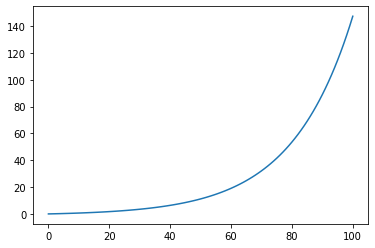

In [156]:
a = [score_from_fitness(a) for a in np.linspace(0,1,101)]
plt.plot(a)

In [162]:
score_from_fitness(1)

147.4131591025766

In [62]:
def num2state2(num,n_nodes):
    '''
    Function description
        Inputs:
            inputs:
        Outputs:
            outputs:
    '''

    number = '{0:0' + str(n_nodes) + 'b}'
    state = number.format(num)
    state = [int(i) for i in state]

    # returns the state
    return state

In [104]:
num2state(9,8)

[1, 0, 0, 1, 0, 0, 0, 0]

In [106]:
state2num(tuple([1, 0, 0, 1, 0, 0, 0, 0]))

9

In [98]:
a.reverse()
print(a)

[1, 0, 0, 0, 0, 0, 0, 0]


In [97]:
# Operating System List
os = ['Windows', 'macOS', 'Linux']
print('Original List:', os)

# List Reverse
os.reverse()

# updated list
print('Updated List:', os)

Original List: ['Windows', 'macOS', 'Linux']
Updated List: ['Linux', 'macOS', 'Windows']
